In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import pandas as pd

# physical review E column width in inches
col_width = 3+3/8
plt.style.use("style.mplstyle") # closer to LaTeX

# time-averaged summary data of hydrocarbon network and carbon skeleton 
from Load_MD_Data import * 

# Degree Distribution Analysis

In this notebook we fit the parameters $p_{\rm HH}$ and $\bar{p}_3$ used to estimate the degree distribution of the carbon skeleton. These are learned separately using two reactions.

First, we compare the degree distribution of the carbon skeleton time-average from MD data to this parametric model (Fig. 8 in text).

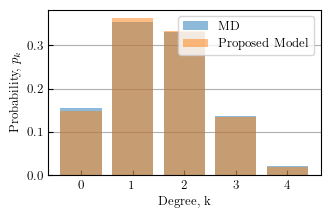

In [2]:
# example histogram to describe degree distribution
plt.figure(figsize=(col_width,2/3*col_width))

# sample to analyze
key = 'C4H10_3600K_1120at'
aux_dict = global_data_avg.loc[key]
alph = 0.5

# from MD
MD_degdist = skeleton_data_avg.loc[key,'DegDist'][:5]
MD_degdist/= MD_degdist.sum()
plt.bar(np.arange(5),MD_degdist,alpha=alph)

# from fit
phh = 2*aux_dict['Nhh']/(2*aux_dict['Nhh']+aux_dict['Nch'])
p3  = aux_dict['CDegDist'][3]/(aux_dict['CDegDist'][3]+aux_dict['CDegDist'][4])
pch = 2.5*(1-phh)/(4-p3) # hcr 2.5, mean deg 4p4 + 3p3=4-p3
aux_deg = np.array([pch,1-pch]) # 0, bond to H, 1, bond to C
approx_degdist      = (1-p3)*np.convolve(aux_deg,np.convolve(aux_deg,np.convolve(aux_deg,aux_deg)))
approx_degdist[:4] +=    p3 *np.convolve(aux_deg,np.convolve(aux_deg,aux_deg))
plt.bar(np.arange(5),approx_degdist,alpha=alph)

# format
plt.legend(['MD','Proposed Model'])
plt.xlabel('Degree, k')
plt.ylabel(r'Probability, $p_k$')
plt.grid(axis='y')
plt.tight_layout()

plt.savefig('../../Figures/DegreeDistribution/DegDistHist_C4H10_3600K_1120at.pdf')

## Fit $p_{HH}$
We first compute the probability that a stub from an H atom is attached to another H atom (i.e. the fraction of H atoms in H2 molecules). This is is done by fitting the reaction
$$2\rm C-H \longleftrightarrow C-C + H-H$$
This has equilibrium constant
$$K = \frac{N_{\rm CC}N_{\rm HH}}{N_{\rm CH}^2} = A_{\rm HH}e^{-C_{\rm HH}/Temp}$$
Bond counts are normalized by atom counts. Each C atom is assumed to participate in 4 bonds where the C atoms with 3 bonds are assumed to be participating in double bonds. In particular, $4N_{\rm C} = 2N_{\rm CC}+N_{\rm CH}$.

In [3]:
Temp_vec = global_data['Temp'].to_numpy()                   # Temperature
HCR_vec  = (global_data['Nh']/global_data['Nc']).to_numpy() # H to C ratio
# prob H atom is in an H2 molecule
Phh_vec  = (2*global_data['Nhh']/(2*global_data['Nhh']+global_data['Nch'])).to_numpy()
# eq. constant to fit to Arrhenius equation
Khh_vec    = (4/HCR_vec-(1-Phh_vec))*Phh_vec/(1-Phh_vec)**2

# Conversion from HCR,Temp and rate constant
def phh_from_fit(HCR,Temp,A,C):
    K = A*np.exp(-C/Temp)
    return 1 - (4/HCR + 1 - np.sqrt((4/HCR-1)**2+16*K/HCR))/2/(1-K)

# data for solving for Arrhenius
# K = A exp(-C/Temp)
# log K = log(A) - C * 1/Temp
train_idx = HCR_vec==2.5 # for C4H10 fit similar performance
test_idx = HCR_vec!=2.5
# train_idx = np.ones_like(HCR_vec,dtype=bool)
# test_idx = HCR_vec==7
xdata = 1/Temp_vec[train_idx]
ydata = np.log(Khh_vec[train_idx])

# least squares
coeffs,residual = np.polyfit(xdata, ydata, 1, full=True)[:2]
print('R2:', 1-residual/sum((ydata - np.mean(ydata))**2) )
Cm, logA = coeffs
Ahh = np.exp(logA)
Chh = -Cm

# print results
# approx 1.28
print('A:','{:6.4f}'.format(Ahh))
# approx 19200
print('C:',round(Chh))

# error
print('\nAverage Absolute Error:', (abs(phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)-Phh_vec)).sum()/len(Phh_vec))
print('Average Percent Error: ', 
      '{:4.2f}'.format(100*(abs(phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)-Phh_vec)/
                            phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)).sum()/len(Phh_vec))+'%')

print('\nAverage Train Percent Error:',
      '{:4.2f}'.format(100*(abs(phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)[train_idx]-Phh_vec[train_idx])
                            /phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)[train_idx]).sum()/sum(train_idx))+'%')
print('Average Test Percent Error: ',
      '{:4.2f}'.format(100*(abs(phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)[test_idx]-Phh_vec[test_idx])/
                            phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)[test_idx]).sum()/sum(test_idx))+'%')

R2: [0.93627018]
A: 4.4056
C: 18566

Average Absolute Error: 0.005637509276669588
Average Percent Error:  9.93%

Average Train Percent Error: 10.68%
Average Test Percent Error:  9.13%


## Fit $p_3$
Here we consider a local reaction that imitates $\rm C_2H_4+H_2 \longleftrightarrow C_2H_6$. In particular this is two bonds that break $\rm C_4-H \to C_3 + H$, where the radical hydrogens quickly form $\rm H_2$. The equilibrium constant is
$$K_{\rm C=C} = \frac{N_{\rm C}\bar{p}_3 N_{\rm H} p_{\rm HH}}{V N_{\rm C}\bar{p}_4}$$
where $\bar{p}_4= 1-\bar{p}_3$ and volume $V$ is proportional to $(12N_{\rm C}+N_{\rm H})Temp$. 

Here we consider three things
- verify that most C atoms are degree 3 or higher (ignoring overcoordinated C atoms w/ 5 bonds),
- show the trend of deg 3 C atoms for simulations initialized to $\rm C_4 H_{10}$ (Fig. 7),
- show that bonds from deg 3 C atoms are less likely to bond to H,
- estimate $K_{\rm C=C}^\text{eff}$ and fit to an Arrhenius law, fitting $p_3$

In [4]:
Error_df = pd.DataFrame()
# errors of assumption 1
Error_df['CErr'] = global_data_avg['CDegDist'].apply(lambda x: 1 - sum(x[3:])) # proportion of C atoms that are neither degree 3 or 4
Error_df['HErr'] = global_data_avg['HDegDist'].apply(lambda x: 1-sum(x[1:]))
# maximum error is for C4H10 5000K where radicals are more frequent, including radical H and carbons bonded to 2 atoms
print('max % deg 2 or less:','{:4.2f}'.format(max(Error_df['CErr'])*100) + '%')
print('max % H deg not 1  :','{:4.2f}'.format(max(Error_df['HErr'])*100)+'%')
# overcoordination error, follows a similar trend. Negligible for T<=4000K
Error_df['COver'] = global_data_avg['CDegDist'].apply(lambda x: x[5]) # <1% except for 5000K
Error_df['HOver'] = global_data_avg['HDegDist'].apply(lambda x: x[2]) # <0.1% except for 5000K
Error_df
# 98 % for all, 99% for 4000K or less

max % deg 2 or less: 1.65%
max % H deg not 1  : 0.96%


,CErr,HErr,COver,HOver
C2H6_3300K,0.000120,0.000865,0.000920,0.000033
C2H6_4000K,0.002055,0.003085,0.003276,0.000236
C2H6_4000K_1280at,0.002511,0.002919,0.003313,0.000247
C4H10_3200K,0.000143,0.000552,0.001011,0.000031
C4H10_3300K,0.000804,0.000585,0.001266,0.000049
C4H10_3400K,0.000814,0.000822,0.001483,0.000058
C4H10_3500K,0.001439,0.001168,0.001829,0.000091
C4H10_3600K,0.002008,0.001423,0.002329,0.000125
C4H10_3600K_1120at,0.001595,0.001334,0.002297,0.000118
C4H10_4000K,0.003895,0.002538,0.004305,0.000310


### trends of $\bar{p}_3$ without normalization

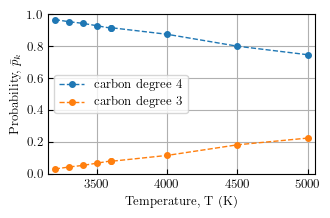

In [5]:
# plot \bar{p}_3 and \bar{p}_4 to show frac. deg. 3/4
plt.figure(figsize=(col_width,2/3*col_width))

idx = global_data_avg['Nc']==global_data_avg['Nh']/2.5
msize = 4
width = 1

plt.plot(global_data_avg.loc[idx,'Temp'],global_data_avg.loc[idx,'CDegDist'].apply(lambda x: x[4]),'o--',
         lw=width,markersize=msize)
plt.plot(global_data_avg.loc[idx,'Temp'],global_data_avg.loc[idx,'CDegDist'].apply(lambda x: x[3]),'o--',
         lw=width,markersize=msize)

plt.legend(['carbon degree 4','carbon degree 3'],loc='center left')

plt.ylim([0,1])
plt.ylabel(r'Probability, $\bar{p}_k$')

plt.xlim([3200-50,5000+50])
plt.xlabel('Temperature, T (K)')

plt.grid('both')
plt.tight_layout()
plt.savefig('../../Figures/DegreeDistribution/DoubleBondRate.pdf')

### Frac of bonds from deg 3 or 4 carbons that bond to H

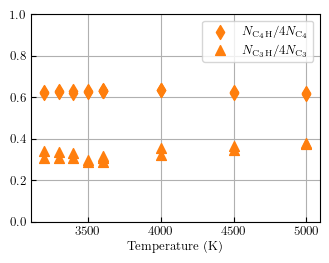

In [6]:
# plot pCH by degree
P3_vec = global_data['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4]))

plt.figure(figsize=(col_width,0.8*col_width))

idx = global_data['Nc']==global_data['Nh']/2.5
# 4 p4 Nc stubs from deg 4 carbons
plt.scatter(global_data['Temp'][idx],(global_data['Nc4h']/4/global_data['Nc']/(1-P3_vec))[idx],c='C1',marker='d',s=50)
# 3 p3 Nc stubs from deg 3 carbons
plt.scatter(global_data['Temp'][idx],(global_data['Nc3h']/3/global_data['Nc']/P3_vec)[idx],c='C1',marker='^',s=50)
plt.ylim([0,1])
plt.xlabel('Temperature (K)',labelpad=2)
plt.legend([r'$N_{{\rm C}_4 {\rm H}}/4N_{{\rm C}_4}$',r'$N_{{\rm C}_3 {\rm H}}/4N_{{\rm C}_3}$'])
plt.tight_layout()
plt.grid()
plt.savefig('../../Figures/DegreeDistribution/pc3h_pc4h.pdf')
# roughly constant, except for methane (CH4) data perhaps due to lack of convergence at 3300K. 
# Constant pc3h and pc4h may be a more accurate model. Future direction...

### Fit $K_{\rm C=C}^\text{eff}$ to an Arrhenius law

In [7]:
# load data
Temp_vec = global_data['Temp'].to_numpy()
HCR_vec  = (global_data['Nh']/global_data['Nc']).to_numpy()
Phh_vec  = (2*global_data['Nhh']/(2*global_data['Nhh']+global_data['Nch'])).to_numpy()
Nh_vec = global_data['Nh'].to_numpy()

P3_vec = global_data['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4])) # prob C atom with 3 neighbors
P4_vec = 1-P3_vec                                                  #  ''          ''  4 neighbors

K3_vec  = P3_vec*Phh_vec/((1-P3_vec) * (12.011/HCR_vec+1)*Temp_vec)             # rate const

# function for p3 from HCR,Temp, and Arrhenius constants for phh+p3
# (1+Phh*K)*P3 = 1
# P3 = 1/(1+Phh*K)
def p3_from_fit(HCR,Temp,Ahh,Chh,A3,C3):
    K = A3*np.exp(-C3/Temp)
    phh = phh_from_fit(HCR,Temp,Ahh,Chh)
    aux = (12.011+HCR)*Temp
    return K*aux/(HCR*phh + K*aux)


# fit Arrhenius Eq.
train_idx = HCR_vec==2.5
test_idx = HCR_vec!=2.5

# idx = np.ones_like(HCR_vec,dtype=bool)
xdata = 1/Temp_vec[train_idx]
ydata = np.log(K3_vec[train_idx])
# least squares
coeffs,residual = np.polyfit(xdata, ydata, 1, full=True)[:2]
print('R2:', 1-residual/sum((ydata - np.mean(ydata))**2) )
Cm, logA = coeffs
A3 = np.exp(logA)
C3 = -Cm

# print result
print('A3:','{:9.8f}'.format(A3))
print('C3:',round(C3))

# errors
print('\nAverage Absolute Error:', (abs(p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)-P3_vec)).sum()/len(P3_vec))
print('Average Percent Error: ', 
      '{:4.2f}'.format(100*(abs(p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)-P3_vec)
                            /p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)).sum()/len(P3_vec))+'%')

print('\nAverage Train Percent Error:',
      '{:4.2f}'.format(100*(abs(p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)[train_idx]-P3_vec[train_idx])
                            /p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)[train_idx]).sum()/sum(train_idx))+'%')
print('Average Test Percent Error: ',
      '{:4.2f}'.format(100*(abs(p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)[test_idx]-P3_vec[test_idx])
                            /p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)[test_idx]).sum()/sum(test_idx))+'%')


R2: [0.94491748]
A3: 0.00064624
C3: 30526

Average Absolute Error: 0.00896674067713744
Average Percent Error:  13.73%

Average Train Percent Error: 11.58%
Average Test Percent Error:  16.00%


# Additional Figures of $p_{\rm HH}$ and $\bar{p}_3$

Here we plot the parameters of our degree distribution model.
- Plot 1 the parameters $p_{\rm HH}$ and $\bar{p}_3$ and compare to their values estimated from the equilibrium constants (Fig. 9).
- Plot 2 the same plot but for the equilibrium constants $K_{\rm HH}^\text{eff}$ and $K_{\rm C=C}^\text{eff}$ (appendix D).

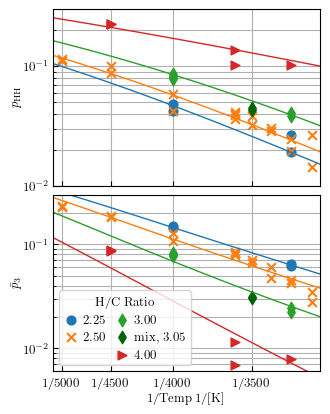

In [8]:
### plot results fits of parameters
# Arrhenius equation
# make mix data almost match CH3 data
msize = 40
width = 1

fig,ax = plt.subplots(2,1,figsize=(col_width,1.25*col_width))
xrange = np.linspace(1/5200,1/2900,100)
h_vec = []
for (i,(HCR,m)) in enumerate([(2.25,'o'),(2.5,'x'),(3,'d'),(3.05,'d'),(4,'>')]):
    if HCR == 3.05: color = 'darkgreen'
    else:           color = 'C'+str(min(i,3)) # 3 for H/C ratio 4
    # main plots
    h_vec.append(ax[0].scatter(1/Temp_vec[HCR_vec==HCR],Phh_vec[HCR_vec==HCR],c=color,marker=m,s=msize))
    ax[1].scatter(1/Temp_vec[HCR_vec==HCR],P3_vec[HCR_vec==HCR],c=color,marker=m,s=msize)
    # fit plots
    if HCR != 3.05:
        ax[0].plot(xrange,phh_from_fit(HCR,1/xrange,Ahh,Chh),lw=width)
        ax[1].plot(xrange,p3_from_fit(HCR,1/xrange,Ahh,Chh,A3,C3),lw=width)

# formatting
b = plt.scatter(0,0,marker='none')
h_vec = h_vec[:2] + [b] + h_vec[2:]
ax[1].legend(labels=['2.25','2.50','','3.00','mix, 3.05','4.00'],handles=h_vec,loc='lower left',title='H/C Ratio',
             handlelength=1,handletextpad=0.5,columnspacing=0.75,ncols=2)
for i in range(2):
    ax[i].grid(which='both')
    ax[i].set_yscale('log')
    ax[i].set_xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","1/4500","1/5000"])
    ax[i].set_xlim([1/5000-4e-6,1/3200+4e-6])
    ax[i].tick_params(axis='y', pad=2.5)
ax[0].set_xticklabels([])
ax[1].set_xlabel('1/Temp 1/[K]',labelpad=2)
ax[0].set_ylabel(r'$p_{\rm HH}$',labelpad=2)
ax[1].set_ylabel(r'$\bar{p}_{3}$',labelpad=2)
ax[0].set_ylim([1e-2,3e-1])
ax[1].set_ylim([6e-3,3e-1])

plt.tight_layout()
fig.subplots_adjust(hspace=.05)

plt.savefig('../../Figures/DegreeDistribution/Deg_Param_Fit.pdf')

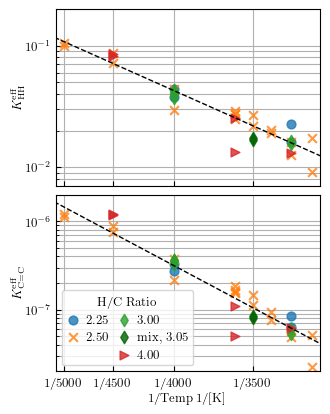

In [9]:
# plots of equilibrium constants
msize = 40
width = 1

fig,ax = plt.subplots(2,1,figsize=(col_width,1.25*col_width))
xrange = np.linspace(1/5200,1/2900,100)
h_vec = []
for (i,(HCR,m)) in enumerate([(2.25,'o'),(2.5,'x'),(3,'d'),(3.05,'d'),(4,'>')]):
    if HCR == 3.05: color = 'darkgreen'
    else:           color = 'C'+str(min(i,3)) # 3 for H/C ratio 4
    # main plots
    h_vec.append(ax[0].scatter(1/Temp_vec[HCR_vec==HCR],Khh_vec[HCR_vec==HCR],c=color,marker=m,s=msize,alpha=.8))
    ax[1].scatter(1/Temp_vec[HCR_vec==HCR],K3_vec[HCR_vec==HCR],c=color,marker=m,s=msize,alpha=.8)
    # fit plots
ax[0].plot(xrange,Ahh*np.exp(-Chh*xrange),lw=width,color='k',linestyle='--')
ax[1].plot(xrange,A3*np.exp(-C3*xrange),lw=width,color='k',linestyle='--')

# formatting
b = plt.scatter(0,0,marker='none')
h_vec = h_vec[:2] + [b] + h_vec[2:]
ax[1].legend(labels=['2.25','2.50','','3.00','mix, 3.05','4.00'],handles=h_vec,loc='lower left',title='H/C Ratio',
             handlelength=1,handletextpad=0.5,columnspacing=0.75,ncols=2)
for i in range(2):
    ax[i].grid(which='both')
    ax[i].set_yscale('log')
    ax[i].set_xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","1/4500","1/5000"])
    ax[i].set_xlim([1/5000-4e-6,1/3200+4e-6])
    ax[i].tick_params(axis='y', pad=2.5)
ax[0].set_xticklabels([])
ax[1].set_xlabel('1/Temp 1/[K]',labelpad=2)
ax[0].set_ylabel(r'$K_{\rm HH}^\text{eff}$',labelpad=2)
ax[1].set_ylabel(r'$K_{\rm C=C}^\text{eff}$',labelpad=2)
ax[0].set_ylim([7e-3,2e-1])
ax[1].set_ylim([2e-8,2e-6])

plt.tight_layout()
fig.subplots_adjust(hspace=.05)

plt.savefig('../../Figures/DegreeDistribution/Deg_Arrh_fit.pdf')

## Error of Degree Distribution
$\ell_1$ error of degree distribution of previous work and the parametric degree distribution model, where $p_{\rm HH}$ and $\bar{p}_3$ are obtained by:
- MD averages
- the equilibrium constants fit to Arrhenius laws

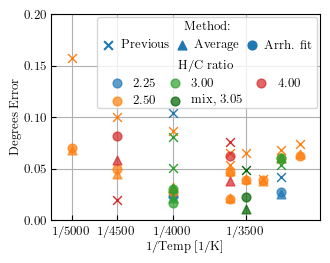

In [10]:
# grab data
# ignore erroneous deg 6+ nodes
DegDist_MD = skeleton_data_avg['DegDist'].apply(lambda x: x[:5]/sum(x[:5]))
HCR_vec  = (global_data_avg['Nh']/global_data_avg['Nc']).to_numpy().astype('float')
Temp_vec = global_data_avg['Temp'].to_numpy().astype('float')



############
### 10RM ###
############
# 10 Reaction Model
Data_10RM = pd.read_csv('../../Data/processed_MD/Degrees_predictions_10reac.csv',index_col=0)
DegErr_10RM = []
for i,idx in enumerate(Data_10RM.index):
    if idx in Data_10RM.index:
        DD10RM = np.array(Data_10RM.loc[idx][:5]/Data_10RM.loc[idx]['NC'])
        DegErr_10RM.append(sum(abs(DD10RM - DegDist_MD[idx])))
DegErr_10RM = np.array(DegErr_10RM)



###########
### AAM ###
###########
P3_vec  = global_data_avg['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4])).to_numpy() 
Phh_vec = (2*global_data_avg['Nhh']/(2*global_data_avg['Nhh']+global_data_avg['Nch'])).to_numpy()
# (3p3+4p4)pch Nc = phc Nh
# pcc = 1-pch = 1-(1-phh)HCR/(4-p3)
Pcc_vec  = 1-(1-Phh_vec)*HCR_vec/(4-P3_vec) # as converted... not directly used

P3_fit   = p3_from_fit(HCR_vec,Temp_vec,Ahh,Chh,A3,C3)
Phh_fit  = phh_from_fit(HCR_vec,Temp_vec,Ahh,Chh)
Pcc_fit  = 1-(1-Phh_fit)*HCR_vec/(4-P3_fit)

# generate degree distribution
nofit_err = np.zeros(len(DegDist_MD))
Arrh_err = np.zeros(len(DegDist_MD))

# find errors
for i in range(len(P3_vec)):
    # without fit
    p3,pcc = P3_vec[i],Pcc_vec[i]
    aux = [1-pcc,pcc]
    DegDist_AAM_nofit = (1-p3)*np.convolve(aux,np.convolve(aux,np.convolve(aux,aux)))
    DegDist_AAM_nofit[:4] += p3*np.convolve(aux,np.convolve(aux,aux))
    nofit_err[i] = sum(abs(DegDist_AAM_nofit - DegDist_MD.iloc[i]))
    # with fit
    p3,pcc = P3_fit[i],Pcc_fit[i]
    aux = [1-pcc,pcc]
    DegDist_AAM = (1-p3)*np.convolve(aux,np.convolve(aux,np.convolve(aux,aux)))
    DegDist_AAM[:4] += p3*np.convolve(aux,np.convolve(aux,aux))
    Arrh_err[i] = sum(abs(DegDist_AAM - DegDist_MD.iloc[i]))



############
# plot 10RM
fig,ax = plt.subplots(figsize=(col_width,0.8*col_width))
msize = 40
for i,hcr in enumerate([2.25,2.5,3,3.05,4]):
    Color = 'C'+str(i)
    if hcr == 3.05: Color = 'darkgreen'
    if hcr == 4: Color = 'C3'
    idx = Data_10RM['HCratio']==hcr
    plt.scatter(1/Data_10RM['Temperature'].loc[idx],DegErr_10RM[idx],c=Color,marker='x',s=msize,lw=1)
# plot AAM
h_vec = []
for i,hcr in enumerate([2.25,2.5,3,3.05,4]):
    Color = 'C'+str(i)
    if hcr == 3.05: Color = 'darkgreen'
    if hcr == 4: Color = 'C3'
    idx = HCR_vec==hcr
    plt.scatter(1/global_data_avg['Temp'].loc[idx],nofit_err[idx],c=Color,marker='^',s=msize,alpha=.7)
    h_vec.append(plt.scatter(1/global_data_avg['Temp'].loc[idx],Arrh_err[idx],c=Color,marker='o',s=msize,alpha=.7))

b = plt.scatter([],[],marker='none') # blank marker
cross = plt.scatter([],[],marker='x',s=msize,c='C0')
triangle = plt.scatter([],[],marker='^',s=msize,c='C0') # no-fit
circle = plt.scatter([],[],marker='o',s=msize,c='C0')   # fit
# h_vec.extend([cross,triangle,circle,b,b])
legend1 = plt.legend(handles=[cross,b,b,b,triangle,b,b,b,circle,b,b,b],
                     labels=['Previous','','','','Average','','','','Arrh. fit','','',''],
                     title = 'Method:', ncol=3,handlelength=1,columnspacing=.5,handletextpad=.5,borderaxespad=0.25)
ax.add_artist(legend1)
plt.legend(handles=h_vec,labels=[r'2.25',r'2.50',r'3.00','mix, 3.05',r'4.00'],
           handlelength=1,columnspacing=1,ncol=3,title = 'H/C ratio',loc = 'upper right',
           bbox_to_anchor=(1,0.88),frameon=False,borderaxespad=0.25,borderpad=1.35)

# format
plt.xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","1/4500","1/5000"])
plt.xlim([1/5000-1e-5,1/3200+1e-5])
plt.xlabel('1/Temp [1/K]',labelpad=2)

plt.yticks([0,0.05,0.1,0.15,0.2])
plt.ylim([0,0.2])
plt.ylabel('Degrees Error',labelpad=2)

plt.grid()
plt.tight_layout()
plt.savefig('../../Figures/DegreeDistribution/Deg_Error_Combined.pdf')